# Modeling

In [1]:
import gzip
import pickle
import random
import warnings
import numpy as np
import matplotlib.pyplot as plt
# warnings.filterwarnings(action='ignore')
%matplotlib inline
plt.style.use('ggplot')

DATA_PATH = '/root/Workspace/DataWarehouse/stMary_RRpo'

In [2]:
with gzip.open(f'{DATA_PATH}/21_230518_resamp_sliced125_filt_patient_stmary.pickle.gzip', 'rb') as f:
    dataset = pickle.load(f)

print(len(dataset), len(dataset[0][0]))

random.seed(42)
random.shuffle(dataset)

pleths = []
resps = []
for ppg, rr in dataset:
    pleths.append(ppg.astype(np.float64))
    resps.append(rr)

pleths = np.asarray(pleths)
resps = np.asarray(resps)
print(pleths.shape, resps.shape)

6508 1800
(6508, 1800) (6508,)


## Normalization

In [3]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

In [4]:
scaler = MinMaxScaler()
scaled_pleths = np.asarray([scaler.fit_transform(pleth.reshape(-1,1)) for pleth in pleths])
print(scaled_pleths.shape, type(scaled_pleths[0][0][0]))

ratio_tr = 0.8
train_x, train_y = scaled_pleths[:int(len(scaled_pleths)*ratio_tr)], resps[:int(len(resps)*ratio_tr)]
val_x, val_y = scaled_pleths[int(len(scaled_pleths)*ratio_tr):], resps[int(len(resps)*ratio_tr):]
print(train_x.shape, train_y.shape)
print(val_x.shape, val_y.shape)

(6508, 1800, 1) <class 'numpy.float64'>
(5206, 1800, 1) (5206,)
(1302, 1800, 1) (1302,)


## Architecture: ResNet 34 Layer

- ResNet 모델 구조는 [논문](https://arxiv.org/pdf/1512.03385.pdf)을 참고하였다. 다만 해당 논문은 ImageNet의 데이터를 실행시키기 위한 것으로 조금의 조정이 필요한데 이를 변경하였을 때 그 내용을 논문에 기재할 필요가 있는지 의문이다.
- 또는 만약 기재해야 한다면 내가 전부터 참고했던 [Bian의 논문](https://ieeexplore.ieee.org/document/9176231)을 참고해도 될 것 같다.

In [5]:
import os
import keras
import tensorflow as tf
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D, Dense, BatchNormalization, Activation, Add, Flatten, Dropout
print(f'Is GPU Avaliable: {tf.config.list_physical_devices("GPU")}')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

2023-05-25 11:01:14.033905: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-25 11:01:14.075017: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-25 11:01:14.731097: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Is GPU Avaliable: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [12]:
class ResidualBlock(Model):
    def __init__(self, filters, kernel_size, strides, identity_mapping=None, *args, **kwargs):
        super(ResidualBlock, self).__init__(*args, **kwargs)
        self.conv1 = Conv1D(filters=filters, kernel_size=kernel_size, strides=strides[0], padding='same', kernel_initializer='HeUniform')
        self.bn1 = BatchNormalization()

        self.conv2 = Conv1D(filters=filters, kernel_size=kernel_size, strides=strides[1], padding='same', kernel_initializer='HeUniform')
        self.bn2 = BatchNormalization()

        self.identity_mapping = identity_mapping
        self.conv_identity = Conv1D(filters=filters, kernel_size=1, strides=strides[0], padding='same', kernel_initializer='HeUniform')
        

    def call(self, inputs, training=None, mask=None):
        identity = inputs
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = Activation('relu')(x)
        x = self.conv2(x)
        x = self.bn2(x, training=training)

        # 448, 64 / 224, 128
        if self.identity_mapping:
            identity = self.conv_identity(inputs)
            # print(inputs.shape, identity.shape)

        x = Add()([x, identity])
        return Activation('relu')(x)

In [13]:
class ResNet34(Model):
    def __init__(self, *args, **kwargs):
        super(ResNet34, self).__init__(*args, **kwargs)
        # self.conv1 = Conv1D(filters=64, kernel_size=7, strides=2)
        # self.max1d = MaxPooling1D(pool_size=3, strides=2)
        self.resnet_block1 = [ResidualBlock(64, 3, (1,1)) for i in range(3)]
        
        self.resnet_block2_entry = ResidualBlock(128, 3, (2,1), identity_mapping=True)
        self.resnet_block2 = [ResidualBlock(128, 3, (1,1)) for i in range(3)]

        self.resnet_block3_entry = ResidualBlock(256, 3, (2,1), identity_mapping=True)
        self.resnet_block3 = [ResidualBlock(256, 3, (1,1)) for i in range(5)]

        self.resnet_block4_entry = ResidualBlock(512, 3, (2,1), identity_mapping=True)
        self.resnet_block4 = [ResidualBlock(512, 3, (1,1)) for i in range(2)]

        self.avg1d = AveragePooling1D(pool_size=2, strides=2, padding='same')
        self.max1d = MaxPooling1D(pool_size=3, strides=2, padding='same')
        self.flatten = Flatten()
        self.d100 = Dense(100, activation='relu')
        self.d50 = Dense(50, activation='relu')
        self.d10 = Dense(10, activation='relu')
        self.d1 = Dense(1)

    
    def call(self, inputs, training=None, mask=None):
        # x = self.conv1(inputs)
        # x = self.max1d(x)

        x = inputs
        for block in self.resnet_block1:
            x = block(x, training=training)

        x = self.resnet_block2_entry(x, training=training)
        for block in self.resnet_block2:
            x = block(x, training=training)

        x = self.resnet_block3_entry(x, training=training)
        for block in self.resnet_block3:
            x = block(x, training=training)
        
        x = self.resnet_block4_entry(x, training=training)
        for block in self.resnet_block4:
            x = block(x, training=training)
        
        
        x = self.avg1d(x)
        x = self.flatten(x)
        x = self.d100(x)
        x = self.d50(x)
        x = self.d10(x)
        return self.d1(x)
    
    @tf.function
    def train_step(self, data):
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)
            loss = self.compiled_loss(y, y_pred)

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        self.compiled_metrics.update_state(y, y_pred)

        return {m.name: m.result() for m in self.metrics}
    
    @tf.function
    def test_step(self, data):
        x, y = data

        y_pred = self(x, training=False)
        self.compiled_loss(y, y_pred)
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}

In [6]:
EPOCHS = 1000
BATCH_SIZE = 256
LR = 0.001
kf = KFold(n_splits=5)
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5),
    # ModelCheckpoint('../models/230522-Resnet', monitor='val_loss', save_best_only=True)
]

model = ResNet34()
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=LR, momentum=0.9, weight_decay=0.0001),
    loss=keras.losses.MeanAbsoluteError(),
    metrics=keras.metrics.MeanAbsoluteError()
)

NameError: name 'ResNet34' is not defined

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y)).batch(BATCH_SIZE)
val_dataset = tf.data.Dataset.from_tensor_slices((val_x, val_y)).batch(BATCH_SIZE)

2023-05-25 11:01:33.595992: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14369 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:73:00.0, compute capability: 7.5


In [15]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_dataset,
        epochs=EPOCHS,
        callbacks=callbacks,
        validation_data=val_dataset
    )

Epoch 1/1000


2023-05-24 13:51:58.136551: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [5206]
	 [[{{node Placeholder/_1}}]]


21/21 [==============================] - ETA: 0s - loss: 20.5604 - mean_absolute_error: 20.5604

2023-05-24 13:52:30.940599: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [1302]
	 [[{{node Placeholder/_1}}]]


21/21 [==============================] - 35s 1s/step - loss: 20.5604 - mean_absolute_error: 20.5604 - val_loss: 239.7426 - val_mean_absolute_error: 239.7426 - lr: 0.0010
Epoch 2/1000
21/21 [==============================] - 22s 1s/step - loss: 5.0804 - mean_absolute_error: 5.0804 - val_loss: 81.3533 - val_mean_absolute_error: 81.3533 - lr: 0.0010
Epoch 3/1000
21/21 [==============================] - 22s 1s/step - loss: 3.5636 - mean_absolute_error: 3.5636 - val_loss: 32.2890 - val_mean_absolute_error: 32.2890 - lr: 0.0010
Epoch 4/1000
21/21 [==============================] - 22s 1s/step - loss: 3.4099 - mean_absolute_error: 3.4099 - val_loss: 15.7346 - val_mean_absolute_error: 15.7346 - lr: 0.0010
Epoch 5/1000
21/21 [==============================] - 22s 1s/step - loss: 1.9273 - mean_absolute_error: 1.9273 - val_loss: 12.1972 - val_mean_absolute_error: 12.1972 - lr: 0.0010
Epoch 6/1000
21/21 [==============================] - 22s 1s/step - loss: 2.5761 - mean_absolute_error: 2.5761 - v

In [16]:
min(history.history['val_loss'])

0.5952494144439697

## Load model

In [8]:
resnet = tf.keras.models.load_model('../models/230522-Resnet/')

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y)).batch(256)
val_dataset = tf.data.Dataset.from_tensor_slices((val_x, val_y)).batch(256)

In [11]:
pred_y = resnet.predict(val_dataset)
print(pred_y.shape, val_y.shape)
abs_err = abs(val_y.reshape(-1,1) - pred_y)
print(f'{np.mean(abs_err)} ± {np.std(abs_err)}')

1/6 [====>.........................] - ETA: 0s

2023-05-25 11:05:03.608930: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [1302]
	 [[{{node Placeholder/_1}}]]


6/6 [==============================] - 2s 319ms/step
(1302, 1) (1302,)
0.5519124542330084 ± 0.4350521281922736


In [10]:
resnet.evaluate(val_dataset)

2023-05-22 14:54:20.241274: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [1302]
	 [[{{node Placeholder/_1}}]]
2023-05-22 14:54:21.707843: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8700


6/6 [==============================] - 5s 275ms/step - loss: 0.5519 - mean_absolute_error: 0.5519


[0.5519124865531921, 0.5519124865531921]

In [12]:
pred_y = resnet.predict(val_x)

41/41 [==============================] - 2s 40ms/step


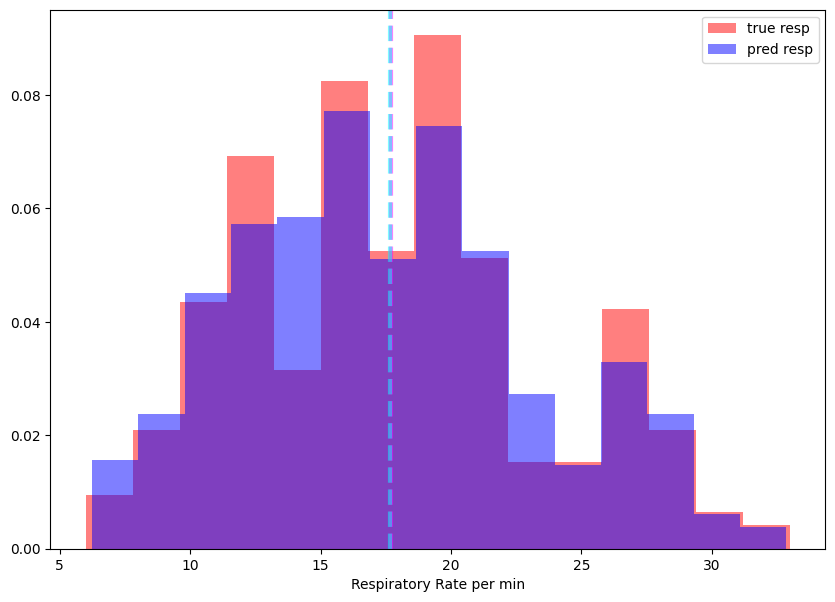

In [34]:
plt.figure(figsize=(10,7))
plt.hist(val_y, bins=15, color='r', density=True, alpha=0.5, label='true resp')
plt.hist(pred_y, bins=15, color='b', density=True, alpha=0.5, label='pred resp')
plt.axvline(val_y.mean(), color='magenta', linestyle='--', linewidth=3, alpha=.5)
plt.axvline(pred_y.mean(), color='cyan', linestyle='--', linewidth=3, alpha=.5)
plt.xlabel('Respiratory Rate per min')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(7,7))
plt.

In [35]:
from scipy import stats

In [39]:
stats.bartlett(val_y, pred_y.reshape(-1))

BartlettResult(statistic=0.05017061662841224, pvalue=0.8227666536957075)

In [40]:
stats.ttest_ind(val_y, pred_y, equal_var=True)

Ttest_indResult(statistic=array([0.17826255], dtype=float32), pvalue=array([0.85853064], dtype=float32))

그러므로 ResNet 모델은 실제 호흡수 값들의 평균에 근사한 예측 호흡수 값 평균을 가진다.